# ROAD TO ABSTRACTION AND REASONING CORPUS PART 2

This notebook is the next part of *ARC COMPLETE BEGINNER GUIDE PART 1*, where I, as a complete begginer, go through each and every notebook and article to gain deeper understanding on the ARC subject. In part 1, I have given the introduction to the ARC problem and basic manipulation of the data. If you have not viewed it yet, you can have a look at it in the link below.

Here is the link: https://www.kaggle.com/giangpt/arc-complete-beginner-guide-part-1

So as I go through notebooks and webpages to extract some insights into the problem. I stumble upon this awesome article, where the author explained his way to solve some of the problems in the competition. If you want to check it out yourself, you can visit [here](https://medium.com/@matlihan/solving-the-abstraction-and-reasoning-corpus-with-logical-reasoning-abductive-reasoner-9845de9714b1)

In the article, the author shows how his approach can be used to solve two examples. In this notebook, I will demonstrate in clear details what his approach is and how he implements it.

# Import the Data and Basic Data Manipulation

This code has been clearly explained in PART 1, so if some part in this code is hard to be understood, feel free to visit my Part 1 [here](http://https://www.kaggle.com/giangpt/arc-complete-beginner-guide-part-1)

In [ ]:
import numpy as np                              #numpy library is used to work with multidimensional array.
import pandas as pd                             #panda used for data manipulation and analysis.
                 
import os                                       #os library is used for loading file to use in the program
import json                                     #json library parses json into a string or dict, and convert string or dict to json file.
from pathlib import Path                        #support path

import matplotlib.pyplot as plt                 #support ploting a figure
from matplotlib import colors                   #colors support converting number or argument into colors

from itertools import combinations              #get different combinations of elements from numpy array.

# get the path for training_task, evaluation_task, and test_task
data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

#from the path above, we load the tests file's directory into our training_tasks, evaluation_tasks, and test_tasks variables
#the sorted() function is just for the list of directory to maintain some order
training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))
test_tasks = sorted(os.listdir(test_path))

#Get the first file of the training_tasks
training_task_file = str(training_path / training_tasks[0])

#Get the first file of the evaluation_tasks
evaluation_task_file = str(evaluation_path / evaluation_tasks[0])

#Get the first file of the test_tasks
test_task_file = str(test_path / test_tasks[0])

#open the file and load it
with open(training_task_file, 'r') as f:   
    #can change training_task_file to evaluation_task_file or test_task_file to have a look at evaluation file or test file
    task = json.load(f)

cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
norm = colors.Normalize(vmin=0, vmax=9)

#plotting the training task and the test task.
#use only for task in training tasks and evaluation tasks
def plot_task(task):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Test-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    

Besides, I will add one more function to plot our predictions later on.

In [ ]:
# plot_pictures is a function to plot our prediction of a specific task, it includes two variables pictures and labels
# pictures will be the list which contains input, output(in case of file in TEST part there is no output) and our prediction.
# labels is the list of labels "Input", "Output", "Prediction" that will be shown in the plotted figure.
def plot_pictures(pictures, labels):
        fig, axs = plt.subplots(1, len(pictures), figsize=(2 * len(pictures), 32))
        for i, (pict, label) in enumerate(zip(pictures, labels)):
            axs[i].imshow(np.array(pict), cmap=cmap, norm=norm)
            axs[i].set_title(label)
        plt.show()

# View the task

First, let's have an overview of the idea, I will demonstrate it through a task in training set. So let's load the task in.

In [ ]:
file_name = "db3e9e38.json"                   #the name of the file containing the task



A function to load the task.

In [ ]:
# Although we know that this file locates in the training set, we generalize it to make sure that no matter
# where the file locates, we can open it. How we can do it is shown in the code below.
def init_task(file_name):
    task_file = None
    task = None
    if file_name in training_tasks:
        task_file = str(training_path / file_name)
    elif file_name in evaluation_tasks:
        task_file = str(evaluation_path / file_name)
    elif file_name in test_tasks:
        task_file = str(test_path / file_name)
    with open(task_file, 'r') as f:   
        task = json.load(f)
    return task

Now it's time to have a look at it.

In [ ]:
task = init_task(file_name)
print(task)
plot_task(task)

As we can see, the task is represented as a dictionary data structure. And we use plot_task() function to turn it into picture that we can visualize.

# OBSERVE

Okay, now I will explain this approach in details.

The approach takes MEMORY as a factor of learning. When you are in the process of preparing for a test, it is highly likely that you will revise the lectures, learn by heart some key contents, and when the test time comes, you try your best to pull those knowledge out of your memory. The same thing happens here, recall that every task has two parts: the "train" part and the "test" part, what we gonna do here is that we will go through the "train" part, save necessary information (in some data structures) using our STRATEGY, then go through the input of "test" part and apply what we have saved in our memory.

That is the overview of what we gonna do. Now being more specific, what is exactly the STRATEGY of getting information that I am talking about. It is simple as this:

   * For each training sample
    * Go through every square in the sample board from left to right, from the bottom to the top. For each grid, observe the grids surrounding it, and save them to our memory. 

   For example, let's have a look at the first training sample of the task. On the left is the input, on the right is the output
   
   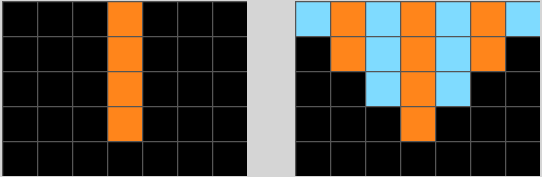

This is the order we gonna look through the sample. From the red square following the direction of the red arrow.

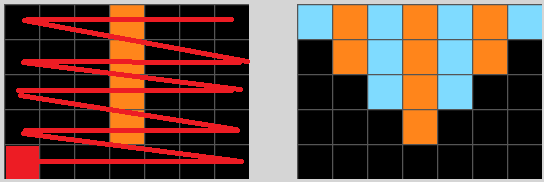

This is how we gonna look at each grid. When we look at the grid there are two possibilities happen:
* There is nothing around.
In the image below, the square we are looking at, which has yellow border, has nothing around it. In that case, we just move on, because if the squares surrounding it are all black, then any prediction might not be yet accurate.

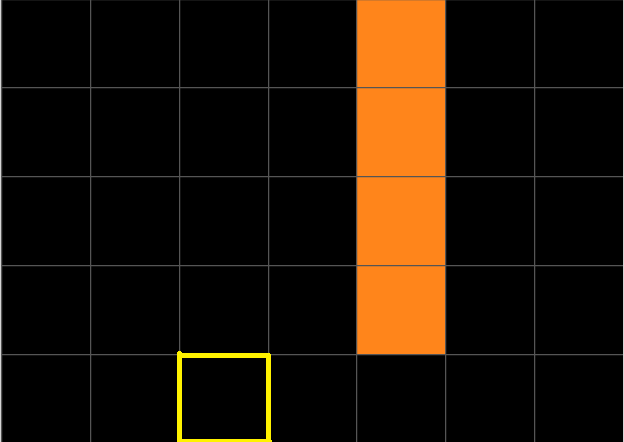

* There is something around.
The square that we mark yellow is the square that we are looking at. As we can see, on the top right corner of it, there is a square in orange.



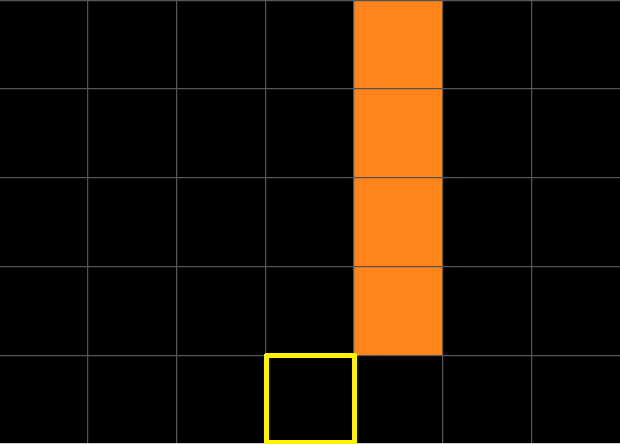

  In this case, we refer to the output of the sample and figure out that the square we are looking at in the input is actually black in the output.
  As a result, we save the following to our memory.
 
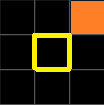

Hey! The square we are looking at is on the edge of the board, how come that we save a 3x3 board to the memory? 
Well, just for consistency, we just add three more squares under the yellow-border grid, the colors of which are all black. How we implement this in the code will be discussed later.

Okay, now, whenever we look at an input square that has its 8 neighbors, 7 of which are black but the top right corner neighbor is orange, then you should predict the square you are looking at to be black.

If your square is in the corner or on the edge and you want to predict its color. Well, just add more squares around it as we do above, and make sure that the square you are looking at is in the center. Then use the same method as before to predict the color of that square.

* *After observing the square and save the info to the memory, assign the color of the output square to the input square that you are looking at*

For example, after doing all of the above steps, we assign the color BLACK of the output square to the input square we are looking at, which is the yellow-border grid. But since the input square we are looking at is already black, so nothing changes.

Let's have a look at another example.



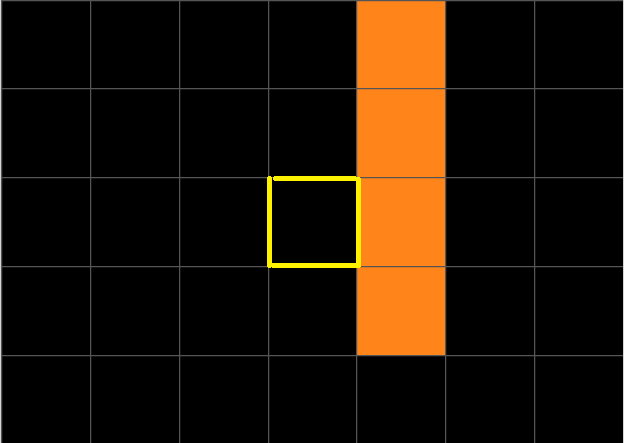

Now the square we are examining is in the middle of the board, looking at its neighbors and we get this:

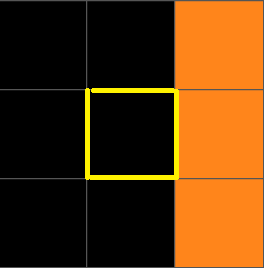

Now, refer to the output to see the yellow-border square color

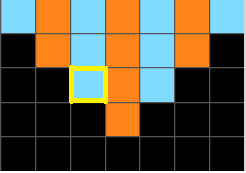

And we find out that it is blue.

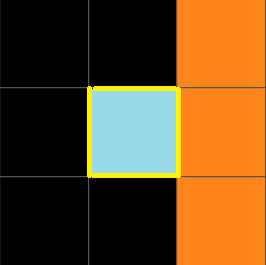

It is time to save it to the memory. SAVE!!

Last step, assign that blue color to the square we are looking at from the input. Now the input becomes

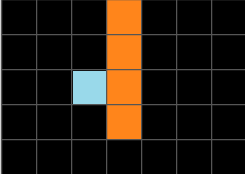

And we continue to visit other squares... And if you want to see all the transformations of the input. You are welcome!!

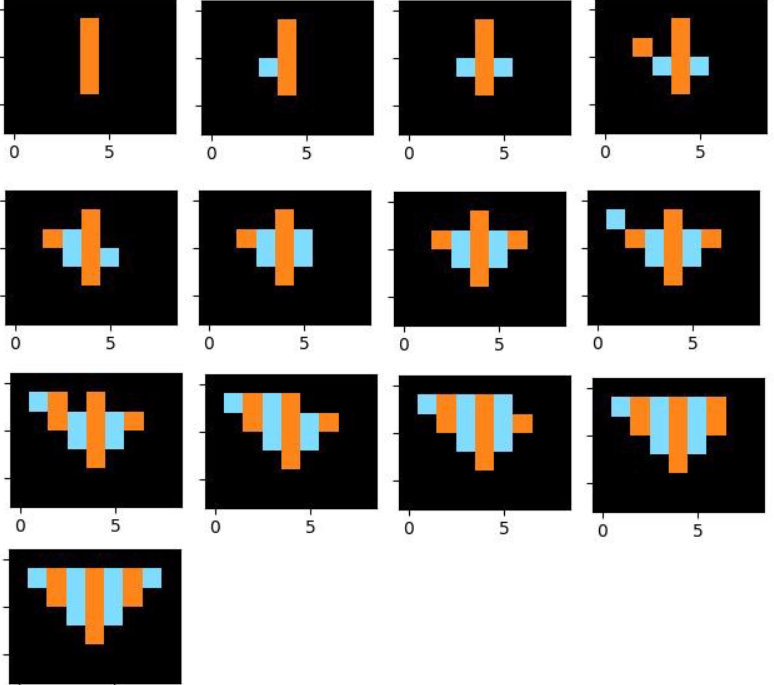

Okay, that is the explanation on how we observe the task's training samples. It is time for some implementations.

Let's now define some of the variables that we are going to use for observation.

In [ ]:
observations = None              #Our memory, the data structure that we gonna use for remembering information
input_ = None                    #As we go through each sample in the task, we will assign the input to input_
output = None                    #As we go through each sample in the task, we will assign the output to output_
input_original = None            #As we go through each sample, we will modify the input as you can see above, so we need
                                 #a variable to keep the original sample's input, and that is input_original mission
#Every grid that we store in the memory for this task is 3x3 grid. If we enumerate the grid from top to bottom, from left to 
#right by number from 0 -> 8, the square that we care about (which is in the center) has index 4. That is what the two
#following variables mean. Stay tuned for how we will use them ...
remove_idxs = 4                  
conclusion_idx = 4

distance = 1                     #how far from a square that we want to observe and save to memory, in this case only 1 because
                                 #we only look at the squares next to it vertically, horizontally or diagonally.
k = 9                            #number of cells in the grid that we save to the memory,3x3 = 9

Next, I will define some helper function for our observation

*1. _pad_image() and _remove_padding()*

In [ ]:
#_pad_image helps us to create a border of zeros around whatever numpy array that we give it.
def _pad_image(image):
    return np.pad(image, distance, constant_values=0)

In [ ]:
#example for the usage of _pad_image
#define arr as a numpy array
arr = np.array([[1,2],[3,4]])
print(arr)
print("after using _pad_image")
print(_pad_image(arr))

Remember the example that we have to add three squares to the bottom of the examined square? _pad_image() do just that, it ensure that each square of the original grid being padded has exactly 8 neighbors.

In [ ]:
def _remove_padding(frame):
    return frame[distance: -distance, distance: -distance]

_remove_padding removes all 0 surrounding the array. This will counter the effect of _pad_image()

*2. _sample_handler(sample)*

In [ ]:
def _sample_handler(sample):
    global input_, output, input_original
    input_ = np.array(sample["input"])
    input_ = _pad_image(input_)
    if "output" in sample:
        output = np.array(sample["output"])
        output = _pad_image(output)
    else:
        output = None
    input_original = input_.copy()

The misson of _sample_handler() is to pad input_, output with 0 outside using the previous function. Also assign input_original as a copy of input_.

*3. _grid_walk()*

In [ ]:
def _grid_walk():
    global input_
    rows, cols = input_.shape[0], input_.shape[1]
    r0 = reversed(range(distance, rows-distance))
    for i in r0:
        r1 = range(distance, cols - distance)
        for j in r1:
            yield i, j

Remember the direction we have to go to examine each sample in "train" part? It is from the bottom to the top, from left to right, and _grid_walk() returns the pair of i, j in the order that enables us to do that.

Note that the input_ in the function is the input_ after being padded by _pad_image().So The reason we have range(distance, rows - distance) and range(distance, cols - distance) for i and j is that we do not want to examine the padded part of the board.

*4. get_neighbours(frame, row, col)*

In [ ]:
def get_neighbours(frame, row, col):
    #get the grid (row, col) and its 8 neighbors as a 3x3 numpy array
    kernel = frame[row-distance:row+distance+1, col-distance:col+distance+1]
    #flatten the kernel and delete the value at index number remove_idxs = 4 (which is the board[i,j]'s value, not its neighbors)
    neighs = np.delete(kernel.flatten(), remove_idxs)
    return neighs

The function returns a 1D color list of all neighbors of the examined square.

In [ ]:
#Example for usage of get_neighbors:
#initiate a numpy array
arr = np.array([[1,2,3],[4,5,6],[7,8,9]])
print(get_neighbours(arr,1,1))

A list return without the value at position (1,1)

*5. get_label(output, row, col)*

In [ ]:
def get_label(output, row, col):
    global distance, conclusion_idx
    kernel = output[row-distance:row+distance+1, col-distance:col+distance+1]
    label = kernel.flatten()[conclusion_idx]
    return label

Remember that at some point we need to refer to the training sample's output to learn what is the color of the examined square? _get_label(output, row, col) do just that. 

*6. sum_neighs(neighs)*

In [ ]:
def _sum_neighs(neighs):
    return neighs.sum()

Just take the neighs numpy array that we have just found in get_neighbors() and calculate the sum of that numpy array. The purpose is to check whether or not all of the square's neighbors are BLACK (number 0). If all of them are BLACK, we move on to examine other square, as mentioned before.

*7. _generate_observation(neighs, conclusion)*

In [ ]:
def _generate_observation(neighs, conclusion):
    return neighs.tolist() + [conclusion] if conclusion is not None else neighs.tolist()

Combine get_neighbors() and get_label() to generate the full observation.

FINALLY, THE OBSERVE() FUNCTION

In [ ]:
def observe(task):
    global observations, input_, output, input_original
    train = task["train"].copy()                                         #get all "train" samples in a task.
    observations = []                                                    #initialize a list of observations.
    for sample in train:                                                 
        _sample_handler(sample)                                          #add padding
        for i, j in _grid_walk():                                        #walk through the grid in determined direction.
            neighs = get_neighbours(input_, i, j)                        #get neighbors' value  
            conclusion = get_label(output, i, j)                         #get the color of the examined grid from the output 
            if _sum_neighs(neighs) > 0:                                  #check if neighbors are not all black
                observation = _generate_observation(neighs, conclusion)  #get the full observation
                if observation not in observations:                      
                    observations.append(observation)                     #add the observation in memory
                input_[i, j] = output[i, j]                              #assign the output's value of (i,j) square to input_[i,j]
    input_ = input_original.copy()  # reset input

As we can see, the code in observe() function strictly follows the step that we have discussed before.

Let's run the observe function

In [ ]:
observe(task)

After observing, let's see what is now in the observation memory. (Through different views)

In [ ]:
#LIST OF NUMBER VIEW
print(observations)

In [ ]:
#COLOR VIEW

def unflatten(arr):
    #take the observations that have been flatten and bring it back to the 3 * 3 shape
    #initiate a 3x3 array
    three_by_three = np.zeros([3,3])
    index = 0
    for i in range(len(three_by_three)):
        for j in range(len(three_by_three[0])): 
            if i == (len(three_by_three) - 1) / 2 and i == j:
                three_by_three[i,j] = arr[-1]
            else:
                three_by_three[i, j] = arr[index]
                index += 1
    return three_by_three

def plot_array():
    global observations
    n = len(observations)
    fig, axs = plt.subplots(1, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(observations):
        t_in = unflatten(observations[i])
        axs[fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[fig_num].set_title(f'Test-{i} in')
        axs[fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[fig_num].set_xticks(list(range(t_in.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()

plot_array()


CSV FILE VIEW:
Note: feature 1 to 8 is the value of the examined square's neighbors, and the conclusion is the value of the examined square.

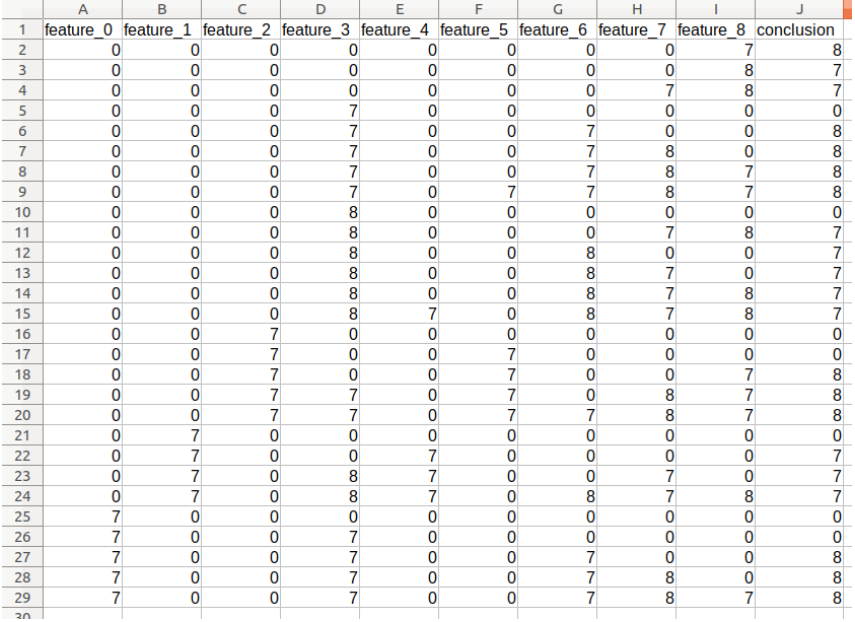



Now, one question arises, can we use what we have observed and apply directly to solve the test output?
There is only one way to know. Let's try it out.

If we want to predict the test part's output right now, the approach is simple. Go through the test grid from bottom to top, from left to right. For each square we go through, we check the neighbors, and search in the memory to find something similar to it, if the pattern of neighbors can be found in the memory, we assign the examined square to the relevant color.

The code below will do just that.

In [ ]:
def my_prediction(task):
    global observations, input_, output, input_original
    colors = [0,7,8]
    all_predictions = []
    for sample in task["test"]:
        _sample_handler(sample)
        for i, j in _grid_walk():
            neighs = get_neighbours(input_, i, j)
            if _sum_neighs(neighs) > 0:
                for color in colors:
                    if (neighs.tolist() + [color]) in observations:
                        input_[i,j] = color
        input_ = _remove_padding(input_)
        guess = input_.tolist()
        all_predictions.append(guess)
    input_ = input_original.copy()
    return all_predictions

# And plot my predictions
def plot_predictions(task, predictions):
    n = len(task["train"]) + len(task["test"])
    fig, axs = plt.subplots(2, n, figsize=(4*n,8), dpi=50)
    plt.subplots_adjust(wspace=0, hspace=0)
    fig_num = 0
    for i, t in enumerate(task["train"]):
        t_in, t_out = np.array(t["input"]), np.array(t["output"])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Train-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'Train-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    for i, t in enumerate(task["test"]):
        t_in, t_out = np.array(t["input"]), np.array(predictions[i])
        axs[0][fig_num].imshow(t_in, cmap=cmap, norm=norm)
        axs[0][fig_num].set_title(f'Test-{i} in')
        axs[0][fig_num].set_yticks(list(range(t_in.shape[0])))
        axs[0][fig_num].set_xticks(list(range(t_in.shape[1])))
        axs[1][fig_num].imshow(t_out, cmap=cmap, norm=norm)
        axs[1][fig_num].set_title(f'My prediction-{i} out')
        axs[1][fig_num].set_yticks(list(range(t_out.shape[0])))
        axs[1][fig_num].set_xticks(list(range(t_out.shape[1])))
        fig_num += 1
    
    plt.tight_layout()
    plt.show()
    
predictions = my_prediction(task)
plot_predictions(task, predictions)     


OOPSIE!!!! What just happens.
One possible guess is that it goes through a square, check the neighbors and cannot find something similar in the memory. And that is exactly what happens right here.

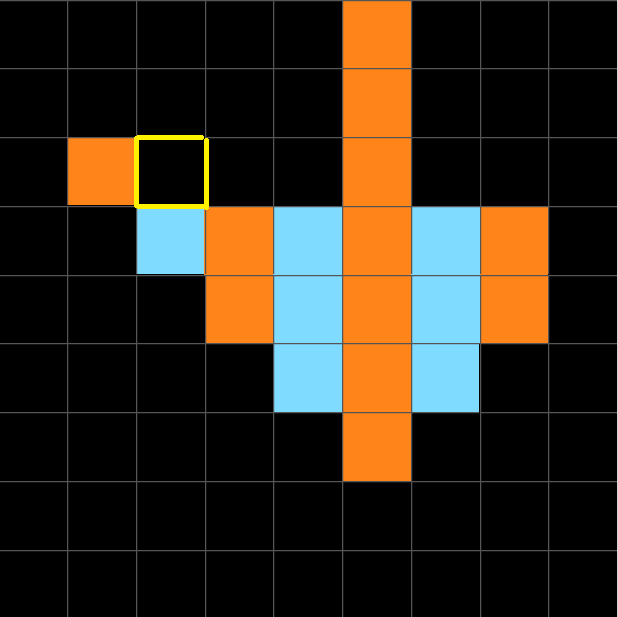

When it comes to examine the yellow-border square. The algorithm checks its neighbours

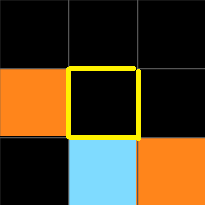

Then the yellow-border square tries all the colors (black, orange, blue) and find if the pattern exists in the memory or not. Unfortunately, there is nothing like that in the memory, so it keeps the color black, which is obviously the wrong answer, and the other wrong answers just follow.

Well, does that mean this approach has failed?
Hmmm, YES and NO.

YES if you only stop right here.
NO if we gonna dig further and extract valuable knowledge from our observations.

The Exam Metaphor now strikes again, if you ONLY learning by heart the lectures' content, you will have a pretty tough time with the test. Because it is likely that the test has many parts that are not in the lectures, but can be INFERRED quite easily from the lectures' content. That leads us to the next PART, that is to create INFERENCE from the observations we have found.

# INFERENCE

So, now, what we can reason from our observations. Let's first have a quick look through the CSV file that we have created before, with a little bit more insight into them.

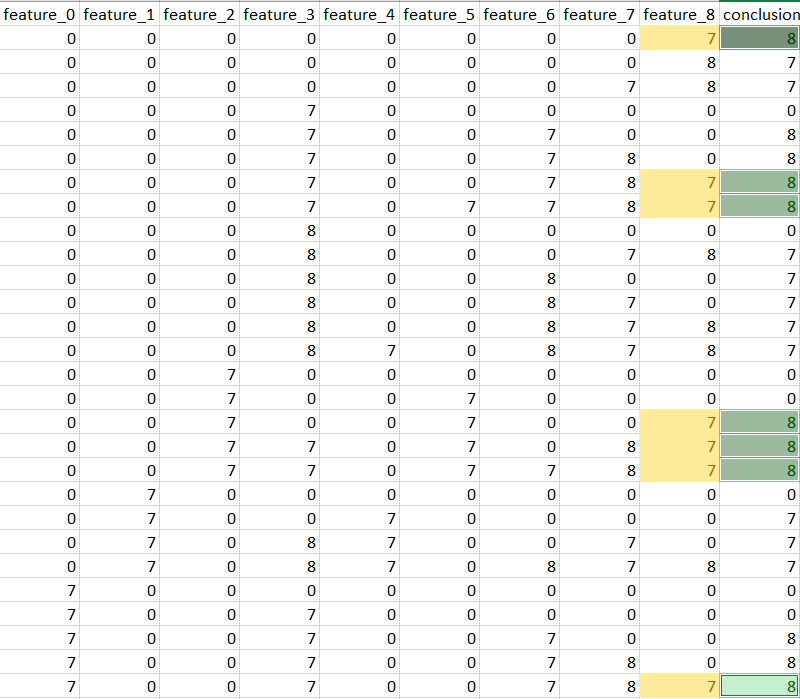

After we go through all of different cases in our memory, we realize that whenever feature_8 is 7, the conclusion is 8, as you can see above. So, it is somewhat reasonable to conclude that if we know that feature_8 is 7, then the examined square should have the value of 8. (Note that number 7 represents the color orange and number 8 represents the color blue)

So gaining only one more piece of knowledge, can we somehow improve the memory-based prediction that we have made before. Lucky for us, the answer is YES. Remember the reason we discuss before about why memory-based prediction cannot give us the correct answer? It is because we encounter a square whose neighbors' pattern cannot be found anywhere in our observed memory. I will show it again here.

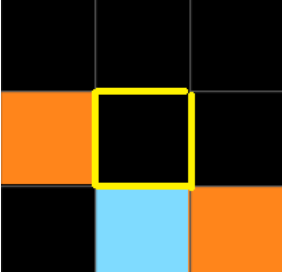

But now, from the key insight that we have discovered before, whenever the feature_8 (bottom right corner) is 7 (orange), then the examined square (square in yellow border) has the value of 8 (which is blue), and that gives us the correct answer. And maybe that one piece of information is just enough to solve our task. 

Anyway, it is time to implement such thing that we have just talked about, in this implementation part, we will not only try to find out only 1 key insight like the one we have done above, but we gonna try to find all of them. So let's do it!!!

First, let's create some more variables

In [ ]:
explanations = None      #data structure we use to store our inference. Explanations will be initialized as a dictionary

Now let's introduce some more helper function for inference

1. _combination_walk():

In [ ]:
def _combination_walk(k):
    r_min = 1
    r_max = 3                                   #we can even set r_max to 8 but for this task, 3 is more than enough
    indices = np.arange(k-1).tolist()           #generate a list in range(k-1), remember that k == 9
    for r in range(r_min, r_max+1):
        for combi in combinations(indices, r):  #generate all diffrent r-element sets from a list, int this case (indices)
            yield combi

2. _generate_explanation()

In [ ]:
def _generate_explanation(observation, combi):
    explanation = ",".join(
        [str(s) if i in combi else "-" for i, s in enumerate(observation[:k-1])])
    return explanation

_generate_explanation() takes two inputs:
+ observation: one of the observations in the memory, observation is a list of 9 numbers, numbers indexed from 0->7 are the 8 features, number indexed 8 is the coclusion of the value in examined square
+ combi: list of position selected that we have generated from  _combination_walk()

Let me give you an example on this function:

In [ ]:
obs = [0,0,0,0,0,0,0,7,8] #the 7 first elements are the features, the last element is the conclusion
combi = [7]            #hinting at position indexed 0 and 7
print(_generate_explanation(obs, combi))

What is the purpose of this function? It generates knowledge and key insights like what we do at the beginning of this INFERENCE PART. Just take the result of this _generate_explanation() function, label it with a conclusion (in our case 8) like this: {-,-,-,-,-,-,-,7 : 8} and store it in our explanations, we have a new explanation that basically means that in a set of features, if the last feature (feature_8) is 7, then the conclusion is 8.

However, we also need something to verify whether our labelling is correct or not. So more about that later on ... Stay tuned!!

3. _explanation_handler()

In [ ]:
# this is the function to check if our labelling we have just talked about is good or bad.
def _explanation_handler(explanations, freq_threshold):
        explanations_ = explanations.copy()          # explanations_ now store all of our labelling
        for explanation in explanations.keys():      
            if len(set(explanations[explanation]["conclusion"])) == 1:  # no contradiction condition, which means our labelling is good
                freq = len(explanations_[explanation]["conclusion"])
                if freq >= freq_threshold:
                    explanations_[explanation]["frequency"] = freq     #How many times a particular labelling happens
                                                                       #For example, in observations the explanation
                                                                       #(-,-,-,-,-,-,-,7 : 8) happens 8 times so frequency = 8
                    explanations_[explanation]["conclusion"] = int(explanations[explanation]["conclusion"][0])
                else:
                    del explanations_[explanation]
            else:
                del explanations_[explanation]
        return explanations_

FINALLY, IT IS TIME FOR THE REASONING.

In [ ]:
def reason():
        global explanations
        freq_threshold = 2
        explanations = {}
        for combi in _combination_walk(k):
            for observation in observations:
                explanation = _generate_explanation(observation, combi)  #generate an explanation by ignore other position 
                                                                         #in observation but position in combi
                if explanation in explanations:
                    explanations[explanation]["conclusion"].append(observation[-1])  #labelling the explanation above
                                                                                     #If the explanation is already in explanations
                                                                                     #just add the label (conclusion) to it.
                else:
                    explanations[explanation] = {"conclusion": [observation[-1]]}
        explanations = _explanation_handler(explanations, freq_threshold)            #check for correctness of the explanation

In [ ]:
reason()

Now, again, let's have look at what we haved achieve after reasoning through different views.

Console view, print out the explanations variable.

In [ ]:
print(explanations)

Now, let's turn that dictionary into CSV File for more viewer friendly.

CSV FILE VIEW (maybe not enough explanations here)

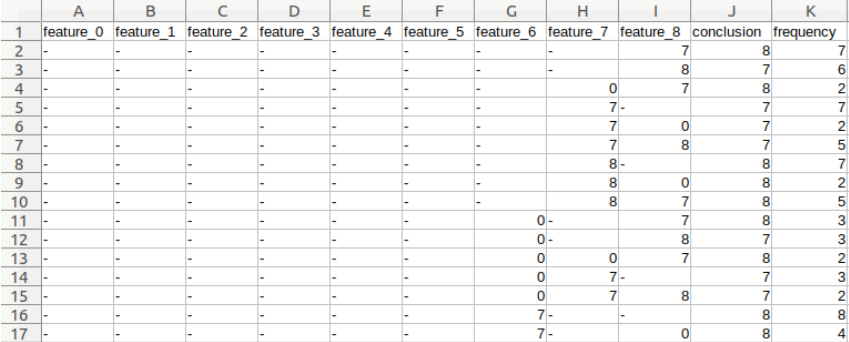

Well, perhaps no colorful grid view for this part.

Is our reasoning strong enough to solve this puzzle? Let's come to the last step to find out.

# PREDICTION

Okay it is time to find out how our approach will succeed. But first, let's define helper functions

1. _decide_conclusion()

In [ ]:
def _decide_conclusion(conclusions):
        conclusion = None
        val = - np.inf
        df = pd.DataFrame(conclusions, columns=["conclusion", "frequency"])
        for conc in df.conclusion.unique():
            val_ = df[(df.conclusion == conc)].frequency.shape[0]
            if val_ > val:
                conclusion, val = conc, val_
        return conclusion

What is the purpose of this function? It is to choose between possible explanations. Let's take an example for clearer understanding.

Assume that you are examining a square (this is just an example, not necessarily to be true), the square has the neighbors [7,0,8,7,0,7,0,7]. Then there are multiple explanations can be generated from this neighbors pattern.
+ Case 1: -,-,-,-,-,-,-,7 ---> this explanation is labelled 8 as the conclusion.
+ Case 2: 7,-,8,-,-,-,-,- ---> this explanation is labelled 0 as the conclusion.
+ Case 3: 7,-,8,-,-,-,-,7 ---> this explanation is labelled 8 as the conclusion.

Suppose that there are only three cases like this (the assumption maybe wrong, but it is just for the purpose of an easy-to-understand example). From here, we can observe that the value 8 is labelled in 2 cases, while number 0 is only labelled once. Then the _decide_conclusion() chooses 8 as the final conclusion and return it.

2. compute_score()

In [ ]:
# remove padding for everything
def _revert_sample_padding():
        global input_original, input_, output
        input_original = _remove_padding(input_original)
        input_ = _remove_padding(input_)
        if output is not None:
            output = _remove_padding(output)

def _compute_score(prediction):
        global output
        score = None
        if output is not None:
            _revert_sample_padding()
            score = 1 if np.array_equal(output, prediction) else 0
        return score

Return 1 if the prediction == the output. Else 0

3. plot_sample(): plotting the prediction

In [ ]:
def plot_sample(predict=None):
    global input_original, output
    pictures = [input_original, output] if output is not None else [input_original]
    labels = ['Input', 'Output'] if output is not None else ["Input"]
    if predict is not None:
        pictures = pictures + [predict]
        labels = labels + ["Predict"]
    plot_pictures(pictures, labels)

FINALLY, IT'S TIME FOR THE PREDICTION AND PLOT IT OUT.

In [ ]:
def predict(is_train=False, visualize=False):
        global input_, explanations
        num_loops = 1
        visualize_prediction = False
        samples = task["test"] if not is_train else task["train"]
        predictions, scores = [], []
        
        for sample in samples:
            _sample_handler(sample)
            prediction = input_.copy()
            for loop in range(num_loops):
                for i, j in _grid_walk():
                    neighs = get_neighbours(prediction, i, j)
                    if _sum_neighs(neighs) > 0:
                        explanation_set, conclusions = [], []
                        for combi in _combination_walk(k):
                            observation = _generate_observation(neighs, None)          #getting the neighbours list
                            explanation = _generate_explanation(observation, combi)    #generate possible explanation by combi
                            if explanation in explanations.keys():
                                con = explanations[explanation]["conclusion"]          
                                freq = explanations[explanation]["frequency"]
                                conclusions.append((con, freq))                        #adding in possible explanations for
                                                                                       #defining the final conclusions.
                                explanation_set.append(explanation)
                        conclusion = _decide_conclusion(conclusions)                   #decide conclusion as explained above.
                        prediction[i, j] = conclusion if conclusion is not None else prediction[i, j]
                        if visualize_prediction:
                            plot_sample(prediction)
            prediction = _remove_padding(prediction)
            predictions.append(prediction)
            scores.append(_compute_score(prediction))
            if visualize:
                plot_sample(prediction)
        return predictions, scores

In [ ]:
predict(visualize = True)

So, that is it, the task has been solved by our approach after 3 steps: Observe, Inference and Predict. Thanks for reading till the end. Upvote if you think this notebook has brought you some values. 

And, as a complete beginner, I really want to have some recommendations on what I should read next about this subject. So I would be so thankful you guys can recommend me some. 

Thank you for reading this far and have a nice day !!!!